In [1]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

sys.path.append('..')
from src.utils.factory import read_yaml
from src.models.networks import read_model
from src.utils.factory import calc_acc
from src.utils.visualize import visualize

### Read Setting

In [2]:
cfg = read_yaml(fpath='../src/config/config.yaml')
cfg.GENERAL.EPOCH = 50000

### Prepare dataset

In [3]:
def create_loader(phase):
    
    bs = 2048
    
    transform = transforms.Compose(
            [transforms.ToTensor()]
            )
    
    dataset = datasets.MNIST(
        root='../data', 
        train=True if phase == 'train' else False,
        download=True, transform=transform
        )
    
    dataloader = DataLoader(dataset)
    
    X, y = [], []
    for img, label in dataloader:
        label_list = [-0.1 for _ in range(10)]
        img = img.numpy()
        label_list[label] = 0.9
        X.append(img / np.linalg.norm(img))
        y.append(label_list)
        
    X, y = np.array(X).squeeze(axis=1), np.array(y, dtype='float32')
    
    if phase == 'train':
        train_id, val_id = train_test_split(
            np.arange(50000),
            test_size=0.2,
            random_state=47
            )
        
        X_train, X_val = X[train_id], X[val_id]
        y_train, y_val = y[train_id], y[val_id]
        
        X_train, X_val = torch.tensor(X_train), torch.tensor(X_val)
        y_train, y_val = torch.tensor(y_train), torch.tensor(y_val)
        
        train_tensor = TensorDataset(X_train, y_train)
        val_tensor = TensorDataset(X_val, y_val)
        
        train_loader = DataLoader(train_tensor, batch_size=bs)
        val_loader = DataLoader(val_tensor, batch_size=1)
        
        return train_loader, val_loader
    
    elif phase == 'test':
        X_test, y_test = torch.tensor(X), torch.tensor(y)
        test_tensor = TensorDataset(X_test, y_test)
        return DataLoader(test_tensor, batch_size=1, shuffle=True)
    
    else:
        NotImplementedError
        
        
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test(net, cfg, test_loader, epsilon):
    
    init_type = cfg.INITIALIZER.TYPE
    input_shape = cfg.MODEL.INPUT_FEATURES
    device_id = cfg.GENERAL.GPUS
    
    criterion = nn.MSELoss(reduction='mean')
    
    correct = 0
    adv_examples = []
    for img, label in test_loader:
        img = img.view(-1, input_shape).to(f'cuda:{device_id[0]}')
        label = label.float().to(f'cuda:{device_id[0]}')
        
        img.requires_grad = True
        
        output = net(img) if not init_type == 'withmp' else net(img).unsqueeze(0)
        
        if output[0].argmax() != label[0].argmax():
            continue
        
        loss = criterion(output, label) / 2
        
        net.zero_grad()
        loss.backward()
        
        data_grad = img.grad.data
        perturbed_img = fgsm_attack(img, epsilon, data_grad)
        
        output = net(perturbed_img)
        
        if output[0].argmax() == label[0].argmax():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                adv_examples.append((output[0].argmax(), label[0].argmax(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                adv_examples.append((output[0].argmax(), label[0].argmax(), adv_ex))
                
    final_acc = correct / float(len(test_loader))
    print(f'Epsilon: {epsilon}\tTest Accuracy = {correct}/{len(test_loader)} = {final_acc}')
    
    return final_acc, adv_examples

In [8]:
init_types = ['vanilla', 'gaussian', 'withmp', 'mexican', 'matern']
epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

test_loader = create_loader(phase='test')

accs_by_types, examples_by_types = [], []
for it in init_types:
    if it == 'gaussian':
        cfg.INITIALIZER.R_SIGMA = 0.5
        cfg.INITIALIZER.S_SIGMA = 0.01
    elif it == 'withmp':
        cfg.INITIALIZER.R_SIGMA = 0.5
        cfg.INITIALIZER.S_SIGMA = 0.01
    elif it == 'mexican':
        cfg.INITIALIZER.M_SIGMA = 0.01
        cfg.INITIALIZER.S_SIGMA = 0.01
    elif it == 'matern':
        cfg.INITIALIZER.R_SIGMA = 0.5
        cfg.INITIALIZER.S_SIGMA = 0.01
    
    cfg.INITIALIZER.TYPE = it
    print(f'----- Initializer type is {it}. -----')
    pretrained_model = f'../pretrained/{it}_best.pth'
    
    net = read_model(cfg)
    net.load_state_dict(torch.load(pretrained_model))
    net.eval()
    
    accs, examples = [], []
    for eps in epsilons:
        acc, ex = test(net, cfg, test_loader, eps)
        accs.append(acc)
        examples.append(ex)
        
    accs_by_types.append(accs)
    examples_by_types.append(examples)

----- Initializer type is vanilla. -----
Epsilon: 0	Test Accuracy = 9287/10000 = 0.9287
Epsilon: 0.01	Test Accuracy = 3036/10000 = 0.3036
Epsilon: 0.02	Test Accuracy = 1320/10000 = 0.132
Epsilon: 0.03	Test Accuracy = 970/10000 = 0.097
Epsilon: 0.04	Test Accuracy = 827/10000 = 0.0827
Epsilon: 0.05	Test Accuracy = 748/10000 = 0.0748
----- Initializer type is gaussian. -----
Epsilon: 0	Test Accuracy = 9447/10000 = 0.9447
Epsilon: 0.01	Test Accuracy = 3848/10000 = 0.3848
Epsilon: 0.02	Test Accuracy = 1892/10000 = 0.1892
Epsilon: 0.03	Test Accuracy = 1483/10000 = 0.1483
Epsilon: 0.04	Test Accuracy = 1309/10000 = 0.1309
Epsilon: 0.05	Test Accuracy = 1192/10000 = 0.1192
----- Initializer type is withmp. -----


/home/kwatanabe/miniconda3/envs/rnf/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([1, 1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epsilon: 0	Test Accuracy = 9340/10000 = 0.934
Epsilon: 0.01	Test Accuracy = 3682/10000 = 0.3682
Epsilon: 0.02	Test Accuracy = 1505/10000 = 0.1505
Epsilon: 0.03	Test Accuracy = 1029/10000 = 0.1029
Epsilon: 0.04	Test Accuracy = 826/10000 = 0.0826
Epsilon: 0.05	Test Accuracy = 723/10000 = 0.0723
----- Initializer type is mexican. -----
Epsilon: 0	Test Accuracy = 9528/10000 = 0.9528
Epsilon: 0.01	Test Accuracy = 4285/10000 = 0.4285
Epsilon: 0.02	Test Accuracy = 2188/10000 = 0.2188
Epsilon: 0.03	Test Accuracy = 1713/10000 = 0.1713
Epsilon: 0.04	Test Accuracy = 1483/10000 = 0.1483
Epsilon: 0.05	Test Accuracy = 1345/10000 = 0.1345
----- Initializer type is matern. -----
Epsilon: 0	Test Accuracy = 9469/10000 = 0.9469
Epsilon: 0.01	Test Accuracy = 4257/10000 = 0.4257
Epsilon: 0.02	Test Accuracy = 2007/10000 = 0.2007
Epsilon: 0.03	Test Accuracy = 1511/10000 = 0.1511
Epsilon: 0.04	Test Accuracy = 1320/10000 = 0.132
Epsilon: 0.05	Test Accuracy = 1182/10000 = 0.1182


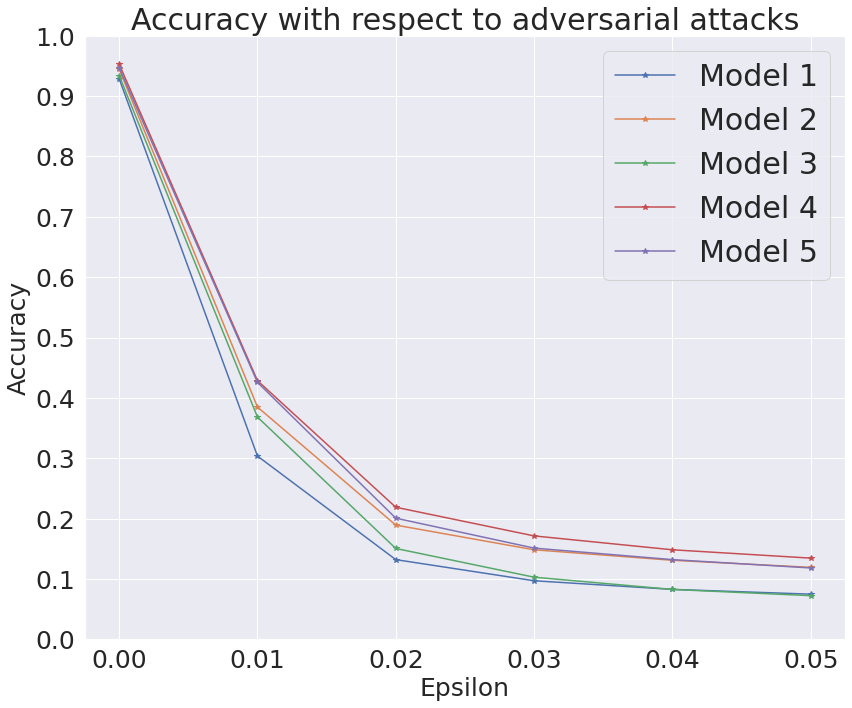

: 

In [11]:
arch_legends = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

plt.figure(figsize=(12, 10))
for i, arch in enumerate(arch_legends):
    plt.plot(epsilons, accs_by_types[i], '*-', label=arch)
plt.title('Accuracy with respect to adversarial attacks', fontsize=30)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=25)
plt.xticks(np.arange(0, .06, step=0.01), fontsize=25)
plt.xlabel('Epsilon', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.legend(fontsize=30)
plt.tight_layout()